In [24]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score,
    roc_curve, auc
)
from sklearn.calibration import CalibratedClassifierCV

np.random.seed(42)
random.seed(42)

In [25]:
# QUESTION 7: Dimensionality Reduction

DATA_PATH = "Project1-ClassificationDataset.csv"
df = pd.read_csv(DATA_PATH)

df = df[["full_text", "root_label", "leaf_label"]].copy()

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

print("Train size:", train_df.shape)
print("Test size:", test_df.shape)

train_texts = train_df["full_text"].astype(str).tolist()
test_texts  = test_df["full_text"].astype(str).tolist()

Train size: (2780, 3)
Test size: (696, 3)


In [26]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(train_df["root_label"])
y_test  = label_encoder.transform(test_df["root_label"])

print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Label mapping: {'climate': np.int64(0), 'sports': np.int64(1)}


In [27]:
# similar to Q3
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"", texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u ', " you ", texter)
    texter = re.sub('`', "", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ', texter)
    cleaner = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(cleaner, '', texter)
    if texter == "":
        texter = ""
    return texter

train_texts_clean = [clean(t) for t in train_texts]
test_texts_clean  = [clean(t) for t in test_texts]

import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger")
nltk.download('averaged_perceptron_tagger_eng')
nltk.download("wordnet")
nltk.download("omw-1.4")

lemmatizer = WordNetLemmatizer()

def _to_wordnet_pos(treebank_tag: str):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    if treebank_tag.startswith('N'):
        return wordnet.NOUN
    if treebank_tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN

_num_like = re.compile(r"^[+-]?(\d+(\.\d*)?|\.\d+)$")

def lemma_tokenizer(text: str):
    tokens = word_tokenize(text.lower())
    tagged = pos_tag(tokens)

    lemmas = []
    for w, tag in tagged:
        if _num_like.match(w):
            continue

        if not any(ch.isalpha() for ch in w):
            continue

        wn_pos = _to_wordnet_pos(tag)
        lemmas.append(lemmatizer.lemmatize(w, pos=wn_pos))
    return lemmas

count_vec = CountVectorizer(
    stop_words="english",
    tokenizer=lemma_tokenizer,
    min_df=3
)

X_train_counts = count_vec.fit_transform(train_texts_clean)
X_test_counts  = count_vec.transform(test_texts_clean)

tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_counts)
X_test_tfidf  = tfidf.transform(X_test_counts)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape:", X_test_tfidf.shape)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[

TF-IDF train shape: (2780, 14250)
TF-IDF test shape: (696, 14250)


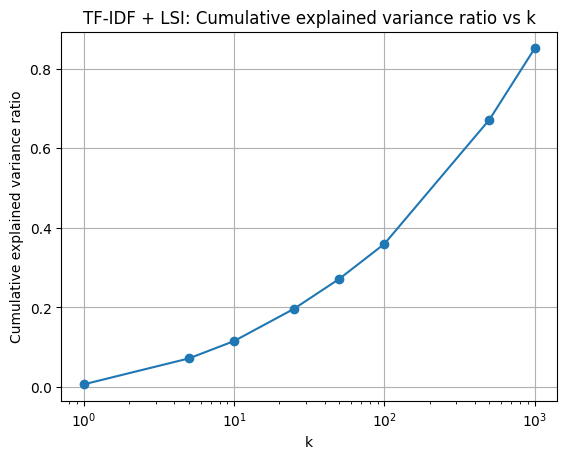

LSI k=25 train shape: (2780, 25)
LSI k=25 test shape: (696, 25)


In [28]:
# 7. a)

k_values = [1, 5, 10, 25, 50, 100, 500, 1000]
max_k = X_train_tfidf.shape[1] - 1

explained_variance_ratio = []
valid_k = []

for k in k_values:
    if k > max_k:
        continue

    svd = TruncatedSVD(n_components=k, random_state=42)
    svd.fit(X_train_tfidf)

    explained_variance_ratio.append(svd.explained_variance_ratio_.sum())
    valid_k.append(k)

plt.figure()
plt.plot(valid_k, explained_variance_ratio, marker="o")
plt.xscale("log")
plt.xlabel("k")
plt.ylabel("Cumulative explained variance ratio")
plt.title("TF-IDF + LSI: Cumulative explained variance ratio vs k")
plt.grid(True)
plt.show()

k = 25

svd_25 = TruncatedSVD(n_components=k, random_state=42)
X_train_lsi_25 = svd_25.fit_transform(X_train_tfidf)
X_test_lsi_25  = svd_25.transform(X_test_tfidf)

print(f"LSI k={k} train shape:", X_train_lsi_25.shape)
print(f"LSI k={k} test shape:", X_test_lsi_25.shape)

In [29]:
# 7. b)

def get_reconstruction_mse(X, X_hat):
    n, m = X.shape
    X_frob_sq = float(np.sum(X.data ** 2))
    Xhat_frob_sq = float(np.sum(X_hat ** 2))
    X_coo = X.tocoo()
    inner_prod = float(np.sum(X_coo.data * X_hat[X_coo.row, X_coo.col]))
    frob_diff_sq = X_frob_sq + Xhat_frob_sq - 2.0 * inner_prod
    return frob_diff_sq / (n * m)

X_train_lsi_hat = X_train_lsi_25 @ svd_25.components_
X_test_lsi_hat  = X_test_lsi_25  @ svd_25.components_

mse_lsi_train = get_reconstruction_mse(X_train_tfidf, X_train_lsi_hat)
mse_lsi_test  = get_reconstruction_mse(X_test_tfidf,  X_test_lsi_hat)

print("k = 25\n")
print("LSI reconstruction MSE:")
print("train:", mse_lsi_train)
print("test:", mse_lsi_test, '\n')

nmf_25 = NMF(n_components=25, init="nndsvda", random_state=42, max_iter=400)

W_train = nmf_25.fit_transform(X_train_tfidf)
W_test  = nmf_25.transform(X_test_tfidf)
H = nmf_25.components_

print("NMF train shape:", W_train.shape)
print("NMF test shape:", W_test.shape)

X_train_nmf_hat = W_train @ H
X_test_nmf_hat  = W_test  @ H

mse_nmf_train = get_reconstruction_mse(X_train_tfidf, X_train_nmf_hat)
mse_nmf_test  = get_reconstruction_mse(X_test_tfidf,  X_test_nmf_hat)

print("NMF reconstruction MSE:")
print("  train:", mse_nmf_train)
print("  test :", mse_nmf_test)

if mse_lsi_train < mse_nmf_train:
    smaller = "LSI"
else:
    smaller = "NMF"

print("\nSmaller reconstruction error:", smaller)
print("LSI/TruncatedSVD does not have a nonnegativity constraint. NMF is constrained to nonnegative factors, so it usually cannot match the optimal SVD reconstruction error.")


k = 25

LSI reconstruction MSE:
train: 5.4628105866023575e-05
test: 5.613464262285954e-05 

NMF train shape: (2780, 25)
NMF test shape: (696, 25)
NMF reconstruction MSE:
  train: 5.502233200703562e-05
  test : 5.635256116921431e-05

Smaller reconstruction error: LSI
LSI/TruncatedSVD does not have a nonnegativity constraint. NMF is constrained to nonnegative factors, so it usually cannot match the optimal SVD reconstruction error.


In [30]:
# 7. c) optional
# based on either GLoVE or LLM embeddings

SVM γ=2000
Confusion Matrix:
[[309  19]
 [ 19 349]]
Accuracy: 0.9454022988505747
Recall: 0.9483695652173914
Precision: 0.9483695652173914
F1-score: 0.9483695652173914

SVM γ=0.0005
Confusion Matrix:
[[299  29]
 [ 18 350]]
Accuracy: 0.9324712643678161
Recall: 0.9510869565217391
Precision: 0.9234828496042217
F1-score: 0.9370816599732262

SVM γ=100000
Confusion Matrix:
[[309  19]
 [ 19 349]]
Accuracy: 0.9454022988505747
Recall: 0.9483695652173914
Precision: 0.9483695652173914
F1-score: 0.9483695652173914



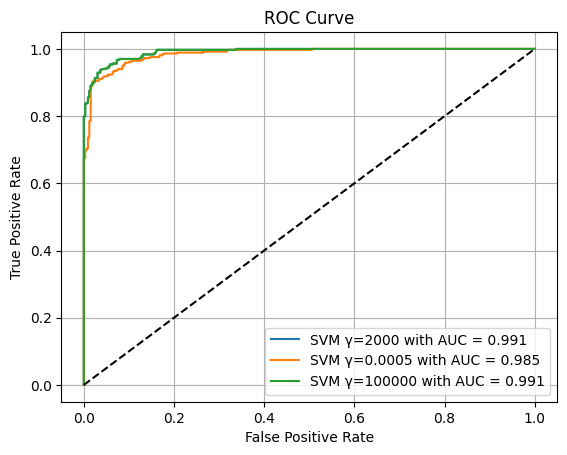

In [37]:
# 8. a)

def analyze_svm(model, test_features, test_labels, model_name=""):
    predicted_labels = model.predict(test_features)
    predicted_probabilities = model.predict_proba(test_features)[:, 1]

    conf_matrix = confusion_matrix(test_labels, predicted_labels)

    accuracy = accuracy_score(test_labels, predicted_labels)
    recall = recall_score(test_labels, predicted_labels)
    precision = precision_score(test_labels, predicted_labels)
    f1_score_ = f1_score(test_labels, predicted_labels)

    false_positive_rate, true_positive_rate, _ = roc_curve(test_labels, predicted_probabilities)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    print(model_name)
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1-score: {f1_score_}\n")

    plt.plot(
        false_positive_rate,
        true_positive_rate,
        label=f"{model_name} with AUC = {roc_auc:.3f}"
    )

plt.figure()
gammas = [2000, 0.0005, 100000]
for gamma in gammas:
    base_svm = LinearSVC(C=gamma, dual=False, max_iter=5000)
    svm = CalibratedClassifierCV(base_svm)
    svm.fit(X_train_lsi_25, y_train)
    analyze_svm(svm, X_test_lsi_25, y_test, model_name=f"SVM γ={gamma}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()



Which SVM performs better?

    The SVM with γ = 2000 (hard margin) performs better.
    It achieves higher accuracy and F1-score than the soft-margin SVM. The confusion matrix is also more balanced with fewer misclassifications.

What about γ = 100000?

    The SVM with γ = 100000 performs identically to γ = 2000.
    This means the classifier has already reached a stable maximum-margin solution, so increasing γ affect performance.

What happens for the soft margin SVM? Why?

    The soft margin SVM does not perform as well because it under-regularizes the margin constraint.

    The confusion matrix has more false positives (29 vs. 19), which lowers the overall accuracy and precision. Since the classifier is too lenient, we get more points that cross the margin and we get more classification errors.

Does the ROC curve reflect the performance of the soft-margin SVM? Why?

    Not completely. ROC curve evaluates ranking across thresholds, but the confusion matrix shows worse performance at a
     decision threshold.

In [32]:
# 8. b)

gammas = [10**k for k in range(-3, 7)]
avg_cv_accuracy = []

for gamma in gammas:
    svm = LinearSVC(C=gamma, dual=False, max_iter=5000)
    scores = cross_val_score(svm, X_train_lsi_25, y_train, cv=5, scoring="accuracy")
    avg_cv_accuracy.append(scores.mean())

best_gamma = gammas[int(np.argmax(avg_cv_accuracy))]

print("Gammas:", gammas)
print("Avg CV accuracy:", [round(x, 4) for x in avg_cv_accuracy])
print("Best gamma:", best_gamma)

Gammas: [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]
Avg CV accuracy: [np.float64(0.9342), np.float64(0.9338), np.float64(0.9388), np.float64(0.946), np.float64(0.9514), np.float64(0.9514), np.float64(0.9518), np.float64(0.9518), np.float64(0.9518), np.float64(0.9518)]
Best gamma: 1000


In [ ]:
base_svm = LinearSVC(C=best_gamma, dual=False, max_iter=5000)
best_svm = CalibratedClassifierCV(base_svm)
best_svm.fit(X_train_lsi_25, y_train)

predicted_labels = best_svm.predict(X_test_lsi_25)
predicted_probs  = best_svm.predict_proba(X_test_lsi_25)[:, 1]

conf_matrix = confusion_matrix(y_test, predicted_labels)

accuracy = accuracy_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1-score: {f1}")

Confusion Matrix:
[[309  19]
 [ 19 349]]
Accuracy : 0.9454022988505747
Precision: 0.9483695652173914
Recall   : 0.9483695652173914
F1-score : 0.9483695652173914


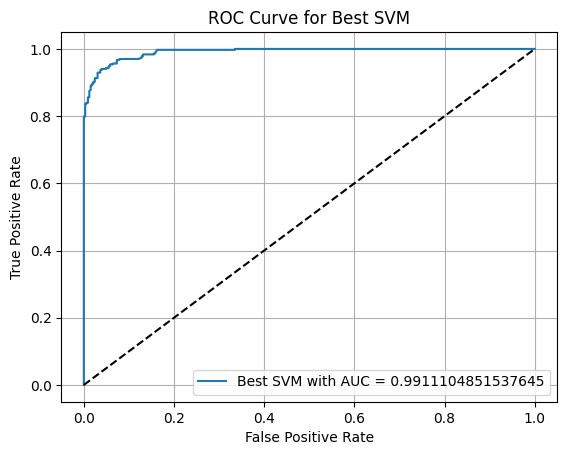

In [35]:
false_positive_rate, true_positive_rate, _ = roc_curve(y_test, predicted_probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure()
plt.plot(false_positive_rate, true_positive_rate, label=f"Best SVM with AUC = {roc_auc}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Best SVM")
plt.legend()
plt.grid(True)
plt.show()